# Knowledge Distillation for LLM Optimization

This notebook implements knowledge distillation to optimize DistilBERT for deployment on edge devices. Knowledge distillation is a technique where a smaller model (student) is trained to mimic the behavior of a larger, more powerful model (teacher).

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add the src directory to the path
sys.path.append('..')

In [2]:
# Import our modules
from src.models.distilbert import load_distilbert_model, get_device
from src.models.knowledge_distillation import create_student_model, DistillationTrainer
from src.data.dataset import load_and_prepare_data, prepare_batch_for_model
from src.utils.metrics import measure_performance, save_metrics, print_metrics

In [9]:
# Configuration
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2  # Binary classification

# Dataset configuration
DATASET_NAME = "glue"
DATASET_CONFIG = "sst2"  # Stanford Sentiment Treebank
BATCH_SIZE = 16
MAX_LENGTH = 128

# Student model configuration
STUDENT_NUM_LAYERS = 2  # Reduced from 6 in the original DistilBERT

# Training configuration
LEARNING_RATE = 5e-5
EPOCHS = 2
TEMPERATURE = 2.0
ALPHA = 0.5  # Balance between hard and soft loss
EVAL_EVERY = 100  # Evaluate every N steps

# Output path
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Device
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cpu


## 1. Load Teacher Model and Data

First, we'll load the teacher model (DistilBERT) and prepare the dataset.

In [10]:
# Load teacher model and tokenizer
print(f"Loading pre-trained {MODEL_NAME} model as teacher...")
teacher_model, tokenizer = load_distilbert_model(MODEL_NAME, NUM_LABELS)

# Load and prepare dataset
print("Loading dataset and preparing data loaders...")
tokenizer, train_dataloader, eval_dataloader = load_and_prepare_data(
    tokenizer, 
    dataset_name=DATASET_NAME, 
    dataset_config=DATASET_CONFIG,
    batch_size=BATCH_SIZE, 
    max_length=MAX_LENGTH
)

Loading pre-trained distilbert-base-uncased model as teacher...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading dataset and preparing data loaders...


## 2. Create the Student Model

Now, we'll create a smaller student model with fewer transformer layers.

In [11]:
# Create student model with reduced number of layers
print(f"Creating student model with {STUDENT_NUM_LAYERS} layers (reduced from 6 in original)...")
student_model = create_student_model(
    teacher_model=teacher_model,
    num_layers=STUDENT_NUM_LAYERS,
    num_labels=NUM_LABELS
)

# Compare the number of parameters in teacher vs student
teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_model.parameters())

print(f"Teacher model parameters: {teacher_params:,}")
print(f"Student model parameters: {student_params:,}")
print(f"Reduction: {(1 - student_params / teacher_params) * 100:.2f}%")

Creating student model with 2 layers (reduced from 6 in original)...
Teacher model parameters: 66,955,010
Student model parameters: 38,603,522
Reduction: 42.34%


## 3. Train the Student Model using Knowledge Distillation

We'll train the student to mimic the teacher's behavior using knowledge distillation.

In [12]:
# Define optimizer for the student model
optimizer = torch.optim.AdamW(student_model.parameters(), lr=LEARNING_RATE)

# Define a function to prepare batch (reusing from baseline)
def prepare_batch(batch, device):
    return prepare_batch_for_model(batch, device)

# Create distillation trainer
trainer = DistillationTrainer(
    teacher_model=teacher_model,
    student_model=student_model,
    temperature=TEMPERATURE
)

In [13]:
# Train the student model
print("Starting knowledge distillation training...")
training_stats = trainer.train(
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    optimizer=optimizer,
    device=DEVICE,
    epochs=EPOCHS,
    alpha=ALPHA,
    eval_every=EVAL_EVERY,
    prepare_batch_fn=prepare_batch
)

Starting knowledge distillation training...


Epoch 1/2:   2%|▏         | 100/4210 [00:51<1:49:20,  1.60s/it]

Step 100/8420, Loss: 0.3491, Eval Accuracy: 0.5092


Epoch 1/2:   5%|▍         | 200/4210 [01:44<1:49:10,  1.63s/it]

Step 200/8420, Loss: 0.3729, Eval Accuracy: 0.5080


Epoch 1/2:   7%|▋         | 300/4210 [02:35<1:46:20,  1.63s/it]

Step 300/8420, Loss: 0.3647, Eval Accuracy: 0.6674


Epoch 1/2:  10%|▉         | 400/4210 [03:27<1:43:11,  1.63s/it]

Step 400/8420, Loss: 0.3042, Eval Accuracy: 0.6594


Epoch 1/2:  12%|█▏        | 500/4210 [04:19<1:39:50,  1.61s/it]

Step 500/8420, Loss: 0.3080, Eval Accuracy: 0.7179


Epoch 1/2:  14%|█▍        | 600/4210 [05:11<1:36:18,  1.60s/it]

Step 600/8420, Loss: 0.3003, Eval Accuracy: 0.7305


Epoch 1/2:  17%|█▋        | 700/4210 [06:04<1:33:46,  1.60s/it]

Step 700/8420, Loss: 0.3266, Eval Accuracy: 0.7615


Epoch 1/2:  19%|█▉        | 800/4210 [06:58<1:37:42,  1.72s/it]

Step 800/8420, Loss: 0.2964, Eval Accuracy: 0.7523


Epoch 1/2:  21%|██▏       | 900/4210 [07:50<1:28:59,  1.61s/it]

Step 900/8420, Loss: 0.2921, Eval Accuracy: 0.7362


Epoch 1/2:  24%|██▍       | 1000/4210 [08:43<1:27:08,  1.63s/it]

Step 1000/8420, Loss: 0.2930, Eval Accuracy: 0.7603


Epoch 1/2:  26%|██▌       | 1100/4210 [09:36<1:23:22,  1.61s/it]

Step 1100/8420, Loss: 0.2537, Eval Accuracy: 0.7557


Epoch 1/2:  29%|██▊       | 1200/4210 [10:28<1:20:44,  1.61s/it]

Step 1200/8420, Loss: 0.2851, Eval Accuracy: 0.7798


Epoch 1/2:  31%|███       | 1300/4210 [11:22<1:18:25,  1.62s/it]

Step 1300/8420, Loss: 0.2684, Eval Accuracy: 0.7844


Epoch 1/2:  33%|███▎      | 1400/4210 [12:14<1:15:22,  1.61s/it]

Step 1400/8420, Loss: 0.2481, Eval Accuracy: 0.7833


Epoch 1/2:  36%|███▌      | 1500/4210 [13:07<1:16:49,  1.70s/it]

Step 1500/8420, Loss: 0.2867, Eval Accuracy: 0.7787


Epoch 1/2:  38%|███▊      | 1600/4210 [14:03<1:14:57,  1.72s/it]

Step 1600/8420, Loss: 0.2752, Eval Accuracy: 0.7901


Epoch 1/2:  40%|████      | 1700/4210 [14:55<1:06:38,  1.59s/it]

Step 1700/8420, Loss: 0.2606, Eval Accuracy: 0.7511


Epoch 1/2:  43%|████▎     | 1800/4210 [15:48<1:06:40,  1.66s/it]

Step 1800/8420, Loss: 0.3130, Eval Accuracy: 0.8016


Epoch 1/2:  45%|████▌     | 1900/4210 [16:43<1:06:38,  1.73s/it]

Step 1900/8420, Loss: 0.2419, Eval Accuracy: 0.7924


Epoch 1/2:  48%|████▊     | 2000/4210 [17:38<58:08,  1.58s/it]  

Step 2000/8420, Loss: 0.3286, Eval Accuracy: 0.7970


Epoch 1/2:  50%|████▉     | 2100/4210 [18:31<56:22,  1.60s/it]

Step 2100/8420, Loss: 0.3059, Eval Accuracy: 0.7787


Epoch 1/2:  52%|█████▏    | 2200/4210 [19:23<53:14,  1.59s/it]

Step 2200/8420, Loss: 0.2518, Eval Accuracy: 0.8073


Epoch 1/2:  55%|█████▍    | 2300/4210 [20:16<52:57,  1.66s/it]

Step 2300/8420, Loss: 0.2358, Eval Accuracy: 0.8005


Epoch 1/2:  57%|█████▋    | 2400/4210 [21:08<47:37,  1.58s/it]

Step 2400/8420, Loss: 0.2379, Eval Accuracy: 0.7959


Epoch 1/2:  59%|█████▉    | 2500/4210 [22:00<47:18,  1.66s/it]

Step 2500/8420, Loss: 0.2578, Eval Accuracy: 0.7775


Epoch 1/2:  62%|██████▏   | 2600/4210 [22:54<44:51,  1.67s/it]

Step 2600/8420, Loss: 0.2860, Eval Accuracy: 0.7936


Epoch 1/2:  64%|██████▍   | 2700/4210 [23:46<39:59,  1.59s/it]

Step 2700/8420, Loss: 0.2459, Eval Accuracy: 0.8142


Epoch 1/2:  67%|██████▋   | 2800/4210 [24:39<37:50,  1.61s/it]

Step 2800/8420, Loss: 0.2902, Eval Accuracy: 0.8096


Epoch 1/2:  69%|██████▉   | 2900/4210 [25:31<34:59,  1.60s/it]

Step 2900/8420, Loss: 0.2687, Eval Accuracy: 0.8039


Epoch 1/2:  71%|███████▏  | 3000/4210 [26:23<33:19,  1.65s/it]

Step 3000/8420, Loss: 0.2725, Eval Accuracy: 0.8062


Epoch 1/2:  74%|███████▎  | 3100/4210 [27:15<29:23,  1.59s/it]

Step 3100/8420, Loss: 0.2498, Eval Accuracy: 0.7924


Epoch 1/2:  76%|███████▌  | 3200/4210 [28:08<28:06,  1.67s/it]

Step 3200/8420, Loss: 0.2994, Eval Accuracy: 0.8050


Epoch 1/2:  78%|███████▊  | 3300/4210 [29:00<24:23,  1.61s/it]

Step 3300/8420, Loss: 0.2705, Eval Accuracy: 0.8177


Epoch 1/2:  81%|████████  | 3400/4210 [29:52<21:12,  1.57s/it]

Step 3400/8420, Loss: 0.2504, Eval Accuracy: 0.8096


Epoch 1/2:  83%|████████▎ | 3500/4210 [30:44<19:02,  1.61s/it]

Step 3500/8420, Loss: 0.2872, Eval Accuracy: 0.7867


Epoch 1/2:  86%|████████▌ | 3600/4210 [31:36<16:13,  1.60s/it]

Step 3600/8420, Loss: 0.2711, Eval Accuracy: 0.8165


Epoch 1/2:  88%|████████▊ | 3700/4210 [32:28<13:29,  1.59s/it]

Step 3700/8420, Loss: 0.2793, Eval Accuracy: 0.8131


Epoch 1/2:  90%|█████████ | 3800/4210 [33:21<11:35,  1.70s/it]

Step 3800/8420, Loss: 0.2461, Eval Accuracy: 0.8119


Epoch 1/2:  93%|█████████▎| 3900/4210 [34:14<08:13,  1.59s/it]

Step 3900/8420, Loss: 0.2710, Eval Accuracy: 0.7833


Epoch 1/2:  95%|█████████▌| 4000/4210 [35:07<05:48,  1.66s/it]

Step 4000/8420, Loss: 0.2524, Eval Accuracy: 0.8119


Epoch 1/2:  97%|█████████▋| 4100/4210 [36:00<03:02,  1.66s/it]

Step 4100/8420, Loss: 0.2485, Eval Accuracy: 0.8096


Epoch 1/2: 100%|█████████▉| 4200/4210 [36:53<00:16,  1.60s/it]

Step 4200/8420, Loss: 0.2323, Eval Accuracy: 0.8119


Epoch 1/2: 100%|██████████| 4210/4210 [36:58<00:00,  1.90it/s]


Epoch 1/2 - Average Loss: 0.2797


Epoch 2/2:   2%|▏         | 90/4210 [00:47<1:52:00,  1.63s/it]

Step 4300/8420, Loss: 0.2260, Eval Accuracy: 0.8119


Epoch 2/2:   5%|▍         | 190/4210 [01:40<1:47:19,  1.60s/it]

Step 4400/8420, Loss: 0.2421, Eval Accuracy: 0.8096


Epoch 2/2:   7%|▋         | 290/4210 [02:34<1:49:15,  1.67s/it]

Step 4500/8420, Loss: 0.2759, Eval Accuracy: 0.8096


Epoch 2/2:   9%|▉         | 390/4210 [03:28<1:44:54,  1.65s/it]

Step 4600/8420, Loss: 0.2593, Eval Accuracy: 0.8039


Epoch 2/2:  12%|█▏        | 490/4210 [04:22<1:44:56,  1.69s/it]

Step 4700/8420, Loss: 0.2616, Eval Accuracy: 0.8039


Epoch 2/2:  14%|█▍        | 590/4210 [05:17<1:43:52,  1.72s/it]

Step 4800/8420, Loss: 0.2199, Eval Accuracy: 0.7959


Epoch 2/2:  16%|█▋        | 690/4210 [06:11<1:37:23,  1.66s/it]

Step 4900/8420, Loss: 0.2623, Eval Accuracy: 0.8108


Epoch 2/2:  19%|█▉        | 790/4210 [07:05<1:35:31,  1.68s/it]

Step 5000/8420, Loss: 0.2425, Eval Accuracy: 0.8016


Epoch 2/2:  21%|██        | 890/4210 [07:59<1:35:19,  1.72s/it]

Step 5100/8420, Loss: 0.2487, Eval Accuracy: 0.8085


Epoch 2/2:  24%|██▎       | 990/4210 [08:53<1:25:07,  1.59s/it]

Step 5200/8420, Loss: 0.2513, Eval Accuracy: 0.7947


Epoch 2/2:  26%|██▌       | 1090/4210 [09:46<1:23:23,  1.60s/it]

Step 5300/8420, Loss: 0.2889, Eval Accuracy: 0.8108


Epoch 2/2:  28%|██▊       | 1190/4210 [10:40<1:23:32,  1.66s/it]

Step 5400/8420, Loss: 0.2508, Eval Accuracy: 0.8085


Epoch 2/2:  31%|███       | 1290/4210 [11:33<1:22:32,  1.70s/it]

Step 5500/8420, Loss: 0.2471, Eval Accuracy: 0.7970


Epoch 2/2:  33%|███▎      | 1390/4210 [12:27<1:17:32,  1.65s/it]

Step 5600/8420, Loss: 0.2240, Eval Accuracy: 0.8108


Epoch 2/2:  35%|███▌      | 1490/4210 [13:21<1:15:28,  1.67s/it]

Step 5700/8420, Loss: 0.2247, Eval Accuracy: 0.8073


Epoch 2/2:  38%|███▊      | 1590/4210 [14:15<1:13:13,  1.68s/it]

Step 5800/8420, Loss: 0.2487, Eval Accuracy: 0.8062


Epoch 2/2:  40%|████      | 1690/4210 [15:08<1:09:22,  1.65s/it]

Step 5900/8420, Loss: 0.2339, Eval Accuracy: 0.8050


Epoch 2/2:  43%|████▎     | 1790/4210 [16:01<1:07:05,  1.66s/it]

Step 6000/8420, Loss: 0.2236, Eval Accuracy: 0.8131


Epoch 2/2:  45%|████▍     | 1890/4210 [16:54<1:06:30,  1.72s/it]

Step 6100/8420, Loss: 0.2605, Eval Accuracy: 0.8188


Epoch 2/2:  47%|████▋     | 1990/4210 [17:47<1:02:50,  1.70s/it]

Step 6200/8420, Loss: 0.2491, Eval Accuracy: 0.8062


Epoch 2/2:  50%|████▉     | 2090/4210 [18:41<58:24,  1.65s/it]  

Step 6300/8420, Loss: 0.2235, Eval Accuracy: 0.8119


Epoch 2/2:  52%|█████▏    | 2190/4210 [19:36<56:16,  1.67s/it]

Step 6400/8420, Loss: 0.2328, Eval Accuracy: 0.8050


Epoch 2/2:  54%|█████▍    | 2290/4210 [20:29<51:22,  1.61s/it]

Step 6500/8420, Loss: 0.2674, Eval Accuracy: 0.8028


Epoch 2/2:  57%|█████▋    | 2390/4210 [21:24<53:54,  1.78s/it]

Step 6600/8420, Loss: 0.2567, Eval Accuracy: 0.8028


Epoch 2/2:  59%|█████▉    | 2490/4210 [22:18<48:40,  1.70s/it]

Step 6700/8420, Loss: 0.2804, Eval Accuracy: 0.8108


Epoch 2/2:  62%|██████▏   | 2590/4210 [23:13<44:49,  1.66s/it]

Step 6800/8420, Loss: 0.2223, Eval Accuracy: 0.8050


Epoch 2/2:  64%|██████▍   | 2690/4210 [24:07<44:10,  1.74s/it]

Step 6900/8420, Loss: 0.2702, Eval Accuracy: 0.8177


Epoch 2/2:  66%|██████▋   | 2790/4210 [25:01<39:24,  1.67s/it]

Step 7000/8420, Loss: 0.2509, Eval Accuracy: 0.8028


Epoch 2/2:  69%|██████▊   | 2890/4210 [25:55<36:36,  1.66s/it]

Step 7100/8420, Loss: 0.2275, Eval Accuracy: 0.8119


Epoch 2/2:  71%|███████   | 2990/4210 [26:49<33:56,  1.67s/it]

Step 7200/8420, Loss: 0.2743, Eval Accuracy: 0.8119


Epoch 2/2:  73%|███████▎  | 3090/4210 [27:43<31:46,  1.70s/it]

Step 7300/8420, Loss: 0.2389, Eval Accuracy: 0.8062


Epoch 2/2:  76%|███████▌  | 3190/4210 [28:37<27:18,  1.61s/it]

Step 7400/8420, Loss: 0.2678, Eval Accuracy: 0.7982


Epoch 2/2:  78%|███████▊  | 3290/4210 [29:30<25:42,  1.68s/it]

Step 7500/8420, Loss: 0.2739, Eval Accuracy: 0.7982


Epoch 2/2:  81%|████████  | 3390/4210 [30:24<22:15,  1.63s/it]

Step 7600/8420, Loss: 0.2508, Eval Accuracy: 0.8039


Epoch 2/2:  83%|████████▎ | 3490/4210 [31:18<20:25,  1.70s/it]

Step 7700/8420, Loss: 0.2233, Eval Accuracy: 0.7913


Epoch 2/2:  85%|████████▌ | 3590/4210 [32:11<16:28,  1.59s/it]

Step 7800/8420, Loss: 0.3404, Eval Accuracy: 0.8085


Epoch 2/2:  88%|████████▊ | 3690/4210 [33:04<14:37,  1.69s/it]

Step 7900/8420, Loss: 0.2287, Eval Accuracy: 0.8028


Epoch 2/2:  90%|█████████ | 3790/4210 [33:58<11:46,  1.68s/it]

Step 8000/8420, Loss: 0.2610, Eval Accuracy: 0.8165


Epoch 2/2:  92%|█████████▏| 3890/4210 [34:52<08:47,  1.65s/it]

Step 8100/8420, Loss: 0.2585, Eval Accuracy: 0.8119


Epoch 2/2:  95%|█████████▍| 3990/4210 [35:44<06:06,  1.67s/it]

Step 8200/8420, Loss: 0.2567, Eval Accuracy: 0.8142


Epoch 2/2:  97%|█████████▋| 4090/4210 [36:37<03:12,  1.60s/it]

Step 8300/8420, Loss: 0.2437, Eval Accuracy: 0.8257


Epoch 2/2: 100%|█████████▉| 4190/4210 [37:30<00:32,  1.64s/it]

Step 8400/8420, Loss: 0.2897, Eval Accuracy: 0.8096


Epoch 2/2: 100%|██████████| 4210/4210 [37:43<00:00,  1.86it/s]

Step 8420/8420, Loss: 0.2344, Eval Accuracy: 0.7982
Epoch 2/2 - Average Loss: 0.2525


## 4. Evaluate and Compare Teacher vs Student

Compare the performance of the original teacher model and our distilled student model.

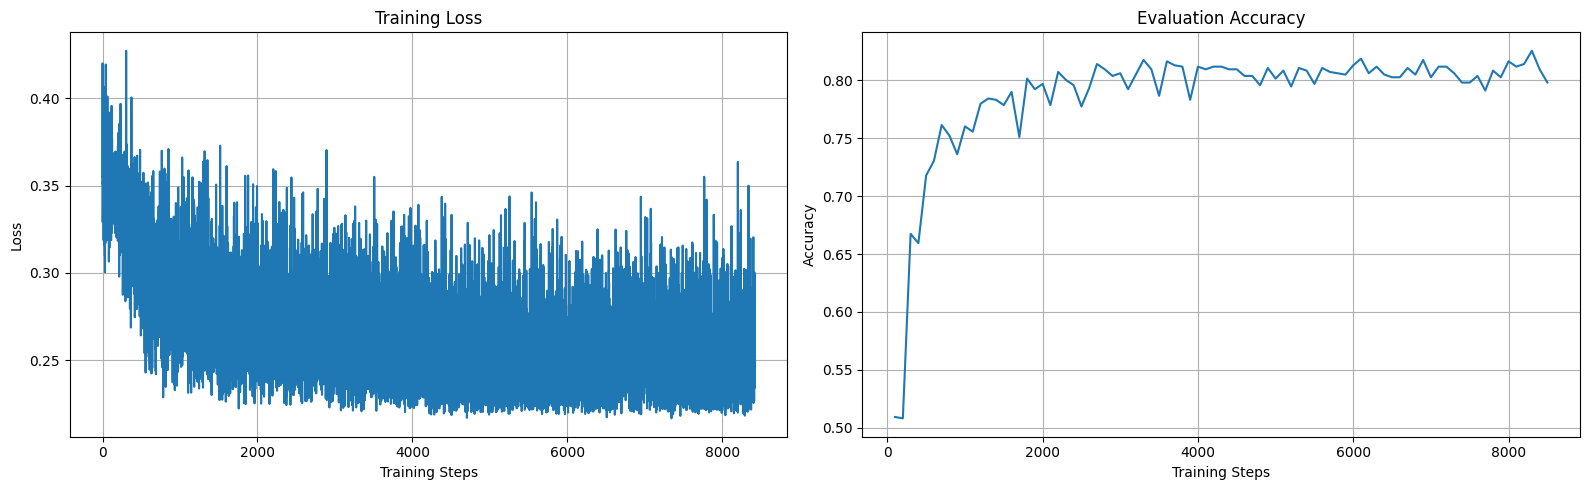

In [14]:
# Plot training loss and evaluation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot training loss
ax1.plot(training_stats['train_losses'])
ax1.set_title('Training Loss')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot evaluation accuracy
eval_steps = [EVAL_EVERY * (i+1) for i in range(len(training_stats['eval_accuracies']))]
ax2.plot(eval_steps, training_stats['eval_accuracies'])
ax2.set_title('Evaluation Accuracy')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Load baseline metrics to compare with
baseline_metrics = torch.load(OUTPUT_DIR / "baseline_metrics.pt")

# Measure student performance
print("Measuring student model performance...")
student_metrics = measure_performance(student_model, eval_dataloader, DEVICE, prepare_batch)

# Save student metrics
save_metrics(student_metrics, file_path=OUTPUT_DIR / "student_metrics.pt")

Measuring student model performance...
Metrics saved to ../outputs/student_metrics.pt


In [16]:
# Print and compare metrics
print("\n===== Teacher Model (Baseline) =====")
print_metrics(
    baseline_metrics, 
    model_name=MODEL_NAME, 
    dataset_info=f"Text Classification - {DATASET_NAME}/{DATASET_CONFIG}"
)

print("\n===== Student Model (Distilled) =====")
print_metrics(
    student_metrics, 
    model_name=f"Distilled {MODEL_NAME} ({STUDENT_NUM_LAYERS} layers)", 
    dataset_info=f"Text Classification - {DATASET_NAME}/{DATASET_CONFIG}"
)


===== Teacher Model (Baseline) =====

Model: distilbert-base-uncased
Task: Text Classification - glue/sst2
Number of parameters: 66,955,010
Model size: 255.41 MB
Average inference latency: 202.79 ms
Accuracy: 0.4908

===== Student Model (Distilled) =====

Model: Distilled distilbert-base-uncased (2 layers)
Task: Text Classification - glue/sst2
Number of parameters: 38,603,522
Model size: 147.26 MB
Average inference latency: 69.99 ms
Accuracy: 0.7982


In [17]:
# Calculate key metrics for comparison
size_reduction = 1 - (student_metrics['model_size_mb'] / baseline_metrics['model_size_mb'])
speed_improvement = baseline_metrics['avg_latency_seconds'] / student_metrics['avg_latency_seconds'] 
accuracy_retention = student_metrics['accuracy'] / baseline_metrics['accuracy']

print("\n===== Performance Comparison =====")
print(f"Size reduction: {size_reduction * 100:.2f}%")
print(f"Speed improvement: {speed_improvement:.2f}x")
print(f"Accuracy retention: {accuracy_retention * 100:.2f}%")

# Check against optimization targets
print("\n===== Optimization Targets =====")
print(f"Size target (50% reduction): {'✅ Achieved' if size_reduction >= 0.5 else '❌ Not achieved'}")
print(f"Accuracy target (90% retention): {'✅ Achieved' if accuracy_retention >= 0.9 else '❌ Not achieved'}")


===== Performance Comparison =====
Size reduction: 42.34%
Speed improvement: 2.90x
Accuracy retention: 162.62%

===== Optimization Targets =====
Size target (50% reduction): ❌ Not achieved
Accuracy target (90% retention): ✅ Achieved


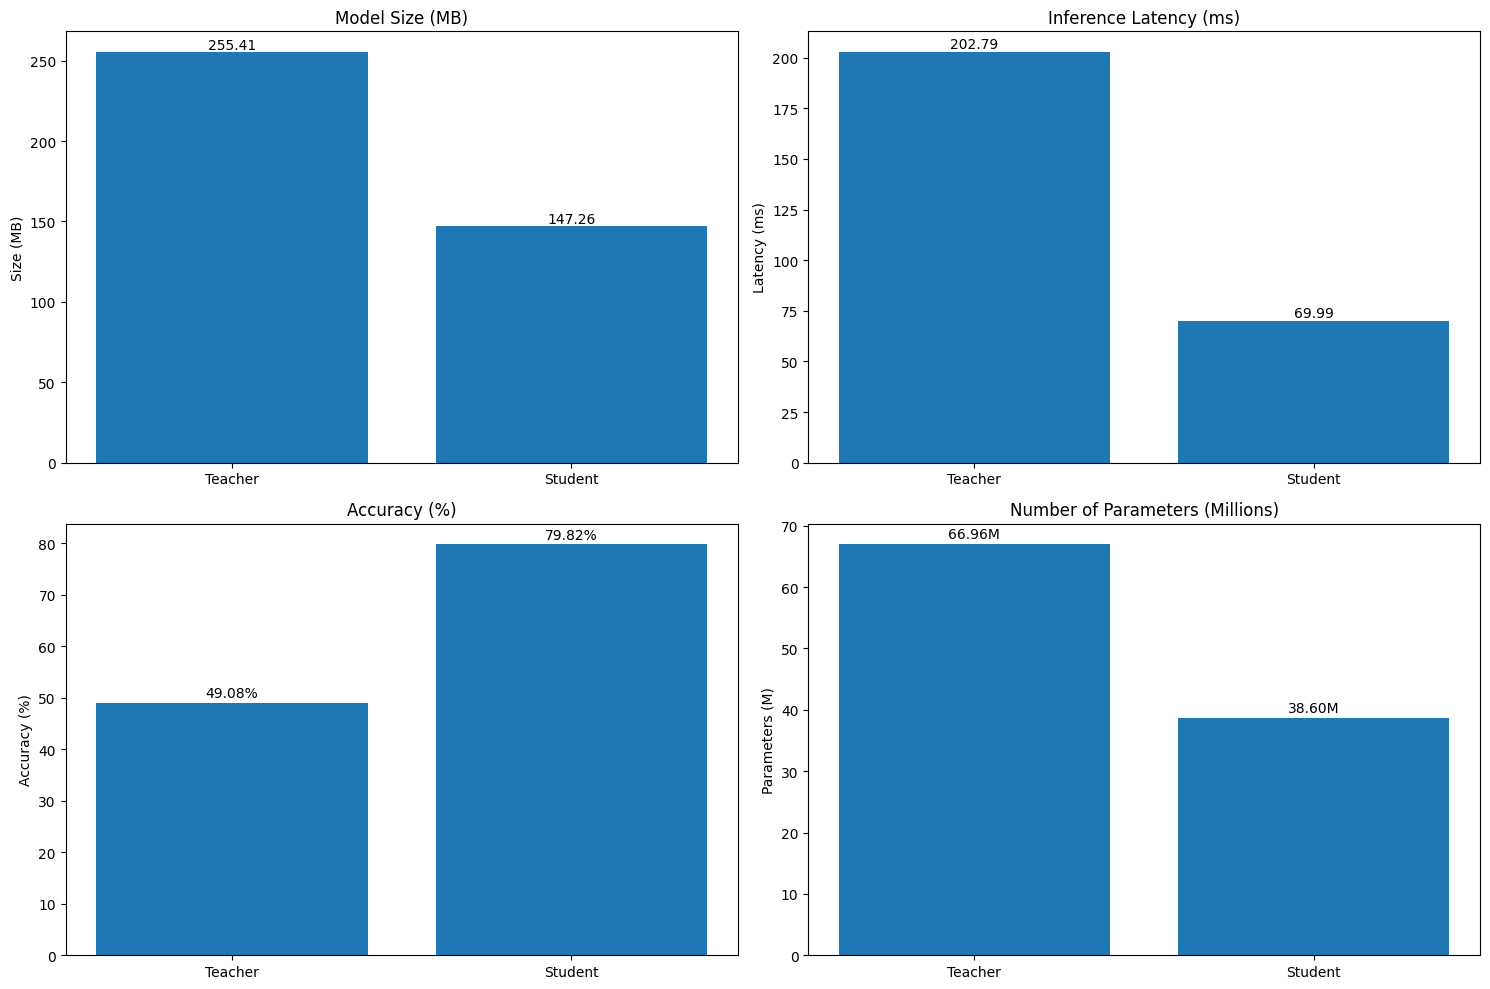

In [18]:
# Plot size, speed, and accuracy comparison
labels = ['Teacher', 'Student']

# Prepare data for comparison
sizes = [baseline_metrics['model_size_mb'], student_metrics['model_size_mb']]
latencies = [baseline_metrics['avg_latency_ms'], student_metrics['avg_latency_ms']]
accuracies = [baseline_metrics['accuracy'] * 100, student_metrics['accuracy'] * 100]
params = [baseline_metrics['num_parameters'] / 1e6, student_metrics['num_parameters'] / 1e6]

# Create bar chart comparisons
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Size comparison
axs[0, 0].bar(labels, sizes)
axs[0, 0].set_title('Model Size (MB)')
axs[0, 0].set_ylabel('Size (MB)')
for i, v in enumerate(sizes):
    axs[0, 0].text(i, v + 2, f"{v:.2f}", ha='center')

# Latency comparison
axs[0, 1].bar(labels, latencies)
axs[0, 1].set_title('Inference Latency (ms)')
axs[0, 1].set_ylabel('Latency (ms)')
for i, v in enumerate(latencies):
    axs[0, 1].text(i, v + 2, f"{v:.2f}", ha='center')

# Accuracy comparison
axs[1, 0].bar(labels, accuracies)
axs[1, 0].set_title('Accuracy (%)')
axs[1, 0].set_ylabel('Accuracy (%)')
for i, v in enumerate(accuracies):
    axs[1, 0].text(i, v + 1, f"{v:.2f}%", ha='center')

# Parameter count comparison
axs[1, 1].bar(labels, params)
axs[1, 1].set_title('Number of Parameters (Millions)')
axs[1, 1].set_ylabel('Parameters (M)')
for i, v in enumerate(params):
    axs[1, 1].text(i, v + 1, f"{v:.2f}M", ha='center')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'knowledge_distillation_comparison.png')
plt.show()

## 5. Save the Optimized Model

Save the student model for later use or deployment.

In [19]:
# Save the student model
student_save_path = OUTPUT_DIR / "distilled_model"
student_save_path.mkdir(exist_ok=True, parents=True)

student_model.save_pretrained(student_save_path)
tokenizer.save_pretrained(student_save_path)

print(f"Student model saved to {student_save_path}")

Student model saved to ../outputs/distilled_model


## 6. Summary and Conclusion

Summarize the results of knowledge distillation for our LLM optimization task.

In [20]:
# Summary of knowledge distillation results
print("===== Knowledge Distillation Summary =====")
print(f"\nTeacher model: {baseline_metrics['num_parameters']:,} parameters, {baseline_metrics['model_size_mb']:.2f} MB")
print(f"Student model: {student_metrics['num_parameters']:,} parameters, {student_metrics['model_size_mb']:.2f} MB")
print(f"Size reduction: {size_reduction * 100:.2f}%")
print(f"\nTeacher accuracy: {baseline_metrics['accuracy'] * 100:.2f}%")
print(f"Student accuracy: {student_metrics['accuracy'] * 100:.2f}%")
print(f"Accuracy retention: {accuracy_retention * 100:.2f}%")
print(f"\nTeacher inference time: {baseline_metrics['avg_latency_ms']:.2f} ms")
print(f"Student inference time: {student_metrics['avg_latency_ms']:.2f} ms")
print(f"Speed improvement: {speed_improvement:.2f}x")

print("\nConclusion:")
if size_reduction >= 0.5 and accuracy_retention >= 0.9:
    print("✅ Knowledge distillation successfully achieved our optimization targets.")
elif size_reduction >= 0.5:
    print("⚠️ Size reduction target was met, but accuracy retention fell below the 90% target.")
elif accuracy_retention >= 0.9:
    print("⚠️ Accuracy retention target was met, but size reduction fell below the 50% target.")
else:
    print("❌ Neither size reduction nor accuracy retention targets were met.")

print("\nNext steps could include:")
print("- Tuning knowledge distillation hyperparameters (temperature, alpha)")
print("- Combining distillation with other optimization approaches")
print("- Further reducing the student model size")

===== Knowledge Distillation Summary =====

Teacher model: 66,955,010 parameters, 255.41 MB
Student model: 38,603,522 parameters, 147.26 MB
Size reduction: 42.34%

Teacher accuracy: 49.08%
Student accuracy: 79.82%
Accuracy retention: 162.62%

Teacher inference time: 202.79 ms
Student inference time: 69.99 ms
Speed improvement: 2.90x

Conclusion:
⚠️ Accuracy retention target was met, but size reduction fell below the 50% target.

Next steps could include:
- Tuning knowledge distillation hyperparameters (temperature, alpha)
- Combining distillation with other optimization approaches
- Further reducing the student model size
